## Evaluating Jazz album prices on Discogs.com
## Data Analysis
- program: 03_analysis.ipynb
- purpose: readin clean .csv output from 02_dataprep 
- date: jan 17, 2021
- created by: chris chan
- Methods:
    - EDA
    - OLS
    - CV for Model Selection
    - Train, Val, Test data
    
- Buyer/seller marketplaces are intersting to track because you would typically think it's a supply demand model. The marketplace for collectibles varies a bit more. Vinyl has experienced a resurgence in the past several years, even in the midst of digital platforms (spotify) and easy access to music. I'm not trying to answer the question why there is a resurgence but rather given the expansion (and continual expansion) of this space, more people are intersted in buying and selling and hence should have some understanding of factors that go into the price.    

## 1. Pre Processing

In [407]:
import pandas as pd
import numpy as np
import seaborn as sns 

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score


Populating the interactive namespace from numpy and matplotlib


**Read-in clean dataframe**

In [406]:
df=pd.read_csv(r'../data/clean/_df_clean.csv')
df.head(3)

,Label,Country,Genre,Release_Date,Style,fpress,spress,tpress,original,rare,...,recyear,rating,votes,haves,wants,sleeve_cond_abbr,media_cond_abbr,seller_rating,media_cond_num,sleeve_cond_num
0,Blue Note – BLP 1502,US,Jazz,Feb 1956,"Hard Bop, Bop",1,0,0,1,0,...,56,4.32,25.0,219.0,301.0,VG,VG+,0.988,6,5
1,Blue Note – BLP 1567,US,Jazz,1957,Hard Bop,0,0,0,0,0,...,57,4.50,16.0,68.0,385.0,VG,VG,1.000,5,5
2,Blue Note – BLP 1508,US,Jazz,May 1956,Hard Bop,1,0,0,1,0,...,56,4.62,29.0,206.0,411.0,VG+,NM or M-,0.988,7,6


In [408]:
df.shape

(3913, 28)

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             3913 non-null   object 
 1   Country           3913 non-null   object 
 2   Genre             3913 non-null   object 
 3   Release_Date      3913 non-null   object 
 4   Style             3913 non-null   object 
 5   fpress            3913 non-null   int64  
 6   spress            3913 non-null   int64  
 7   tpress            3913 non-null   int64  
 8   original          3913 non-null   int64  
 9   rare              3913 non-null   int64  
 10  dgroove           3913 non-null   int64  
 11  sealed            3913 non-null   int64  
 12  promo             3913 non-null   int64  
 13  xnotes            3913 non-null   int64  
 14  price             3913 non-null   float64
 15  artist            3913 non-null   object 
 16  album             3913 non-null   object 


In [410]:
df.describe()

,fpress,spress,tpress,original,rare,dgroove,sealed,promo,xnotes,price,recyear,rating,votes,haves,wants,seller_rating,media_cond_num,sleeve_cond_num
count,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000,3913.000000
mean,0.251469,0.075390,0.092768,0.233836,0.066445,0.221825,0.064401,0.079734,0.530028,135.105699,62.202658,4.242650,21.568617,192.006900,203.996933,0.992979,5.848709,5.547151
std,0.433913,0.264053,0.290144,0.423323,0.249090,0.415527,0.245497,0.270916,0.499161,201.469615,3.835321,0.981901,29.241764,253.281713,275.123200,0.020049,1.026046,1.106491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,52.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,59.000000,4.220000,4.000000,42.000000,59.000000,0.994000,5.000000,5.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,75.000000,62.000000,4.460000,11.000000,99.000000,121.000000,0.999000,6.000000,6.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,140.000000,65.000000,4.670000,26.000000,241.000000,255.000000,1.000000,7.000000,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000,70.000000,5.000000,210.000000,1943.000000,3685.000000,1.000000,8.000000,8.000000


**Pair Plot on numeric FULL DF**

In [411]:
df_pair=df.drop(['fpress','spress','tpress','original','rare','sealed','dgroove','promo','xnotes'],axis=1)

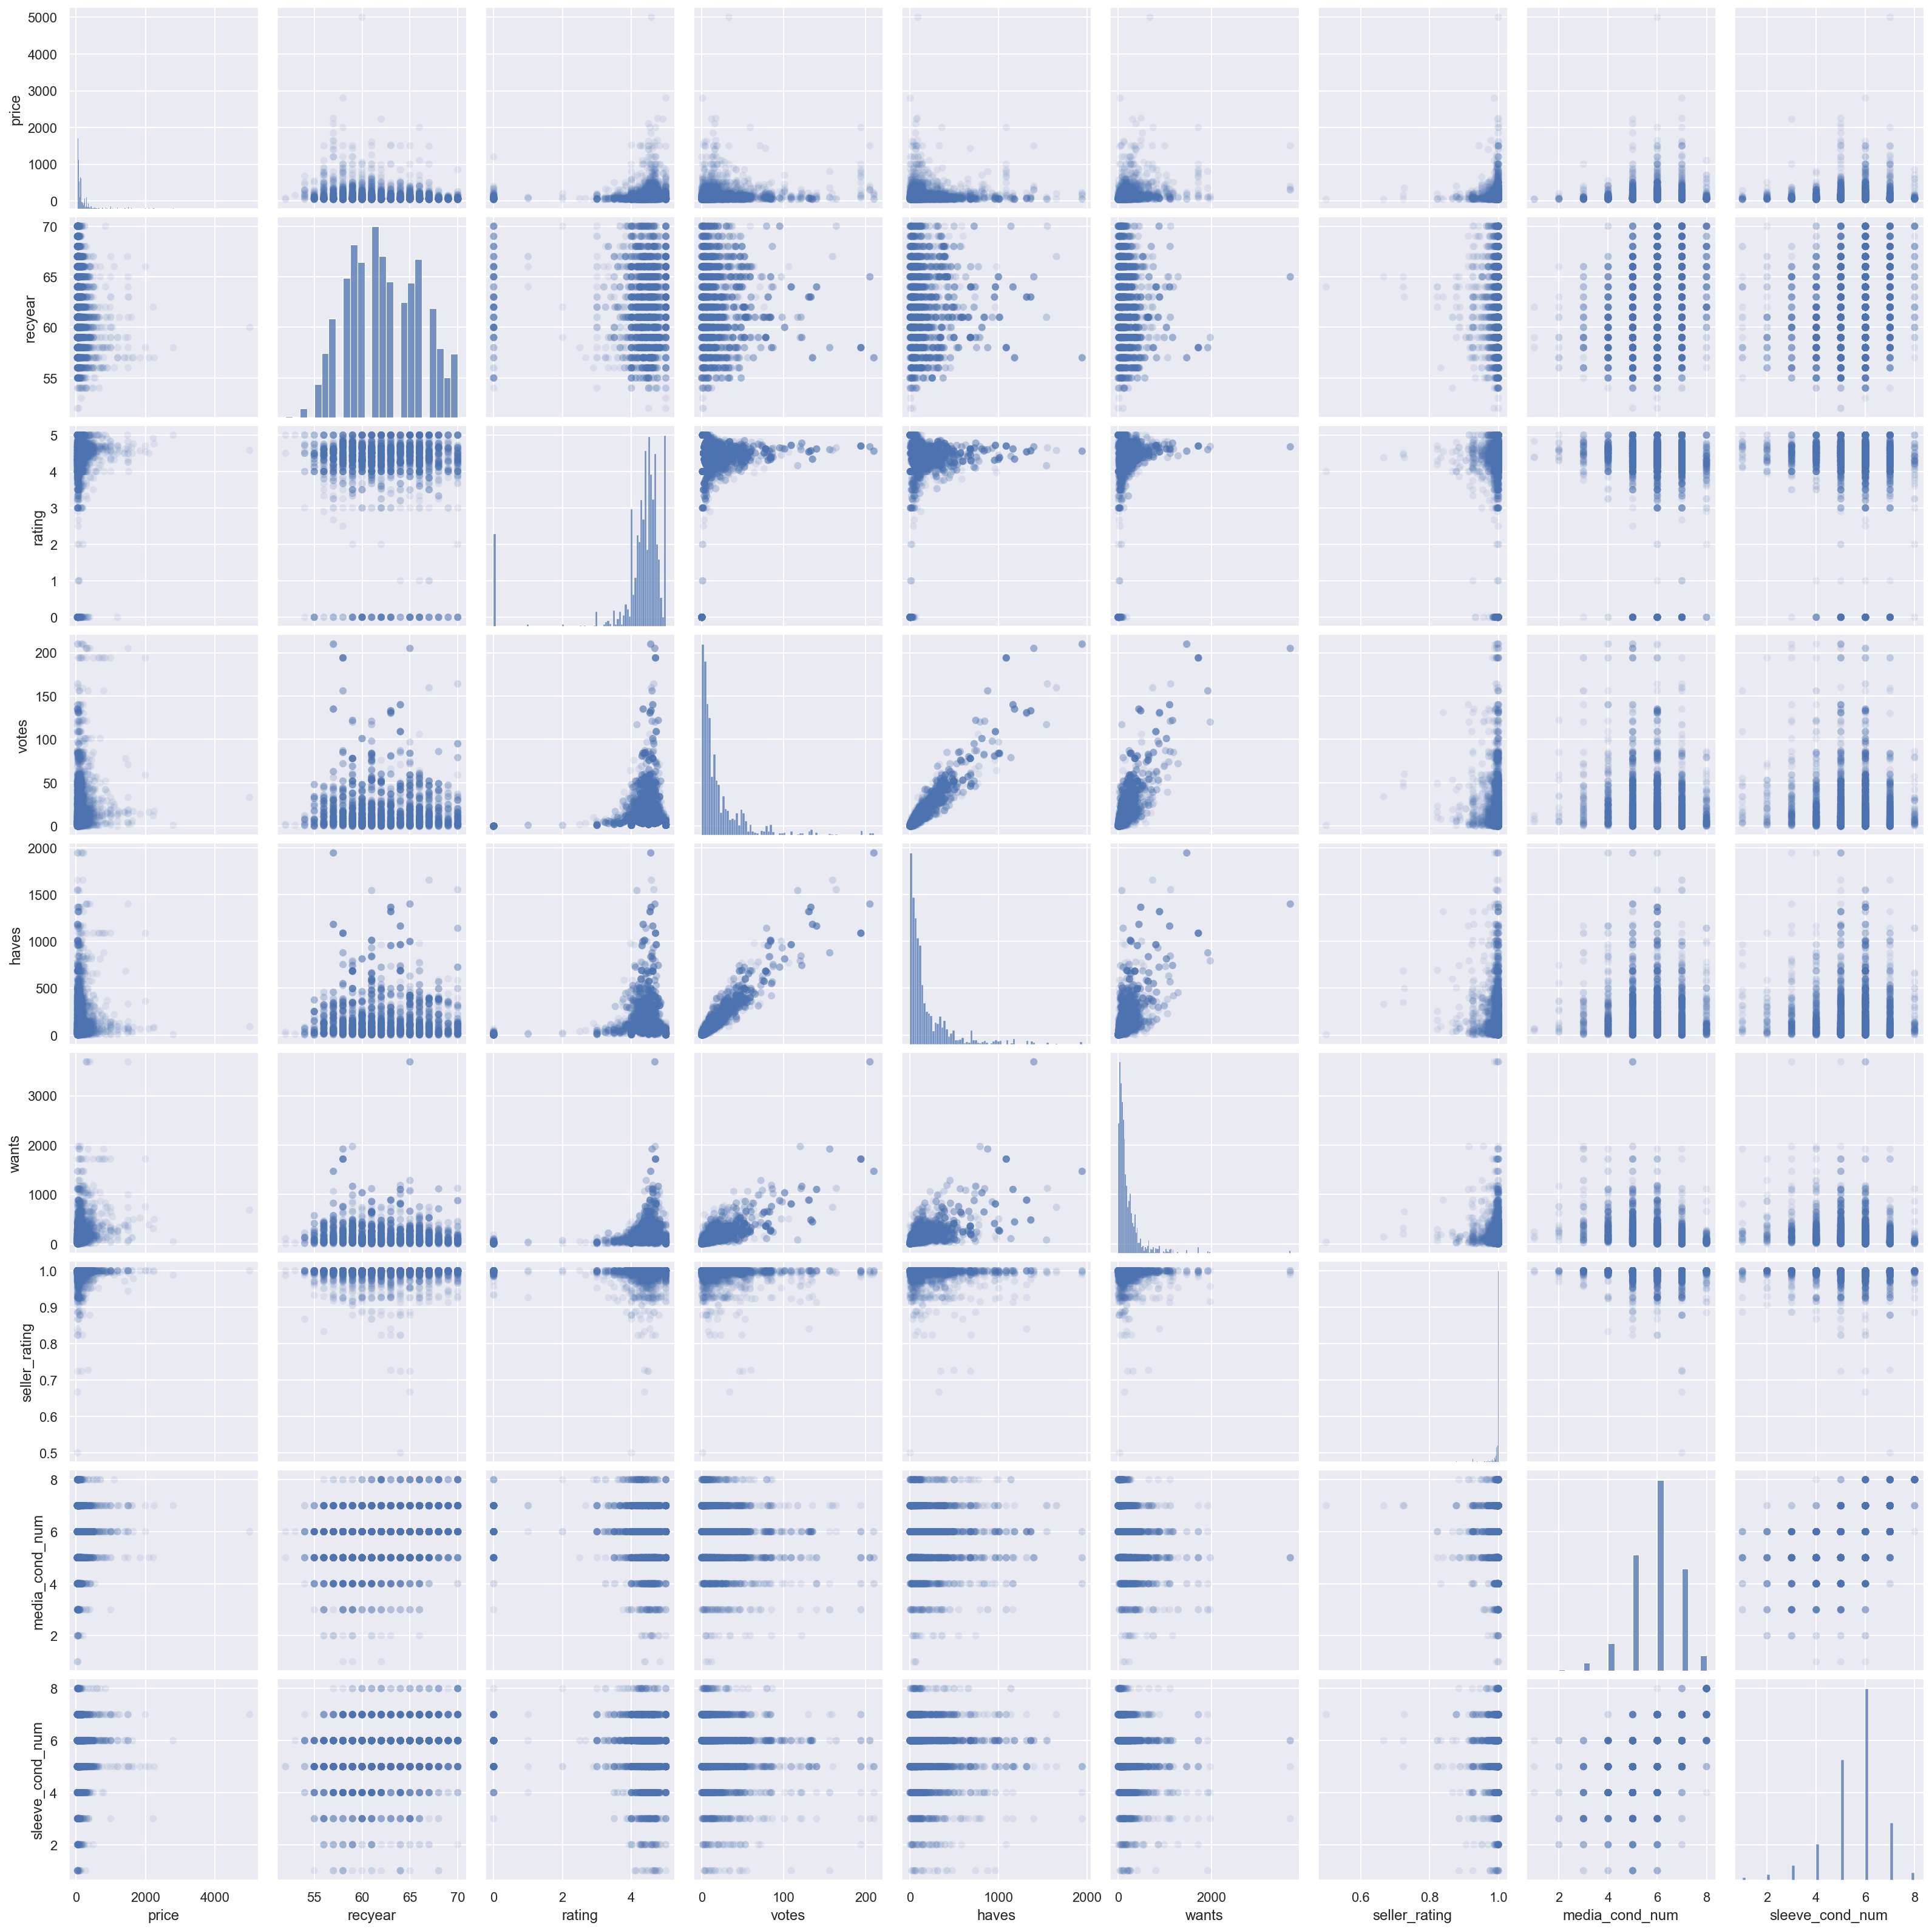

In [412]:
sns.pairplot(df_pair,plot_kws=dict(alpha=.1,edgecolor='none'))

**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price
- maybe change year to categorical
- group F and P sleeve/media ratings

**Check for correlated variables**

In [413]:
df_corr = df.corr()
#df_corr

<AxesSubplot:>

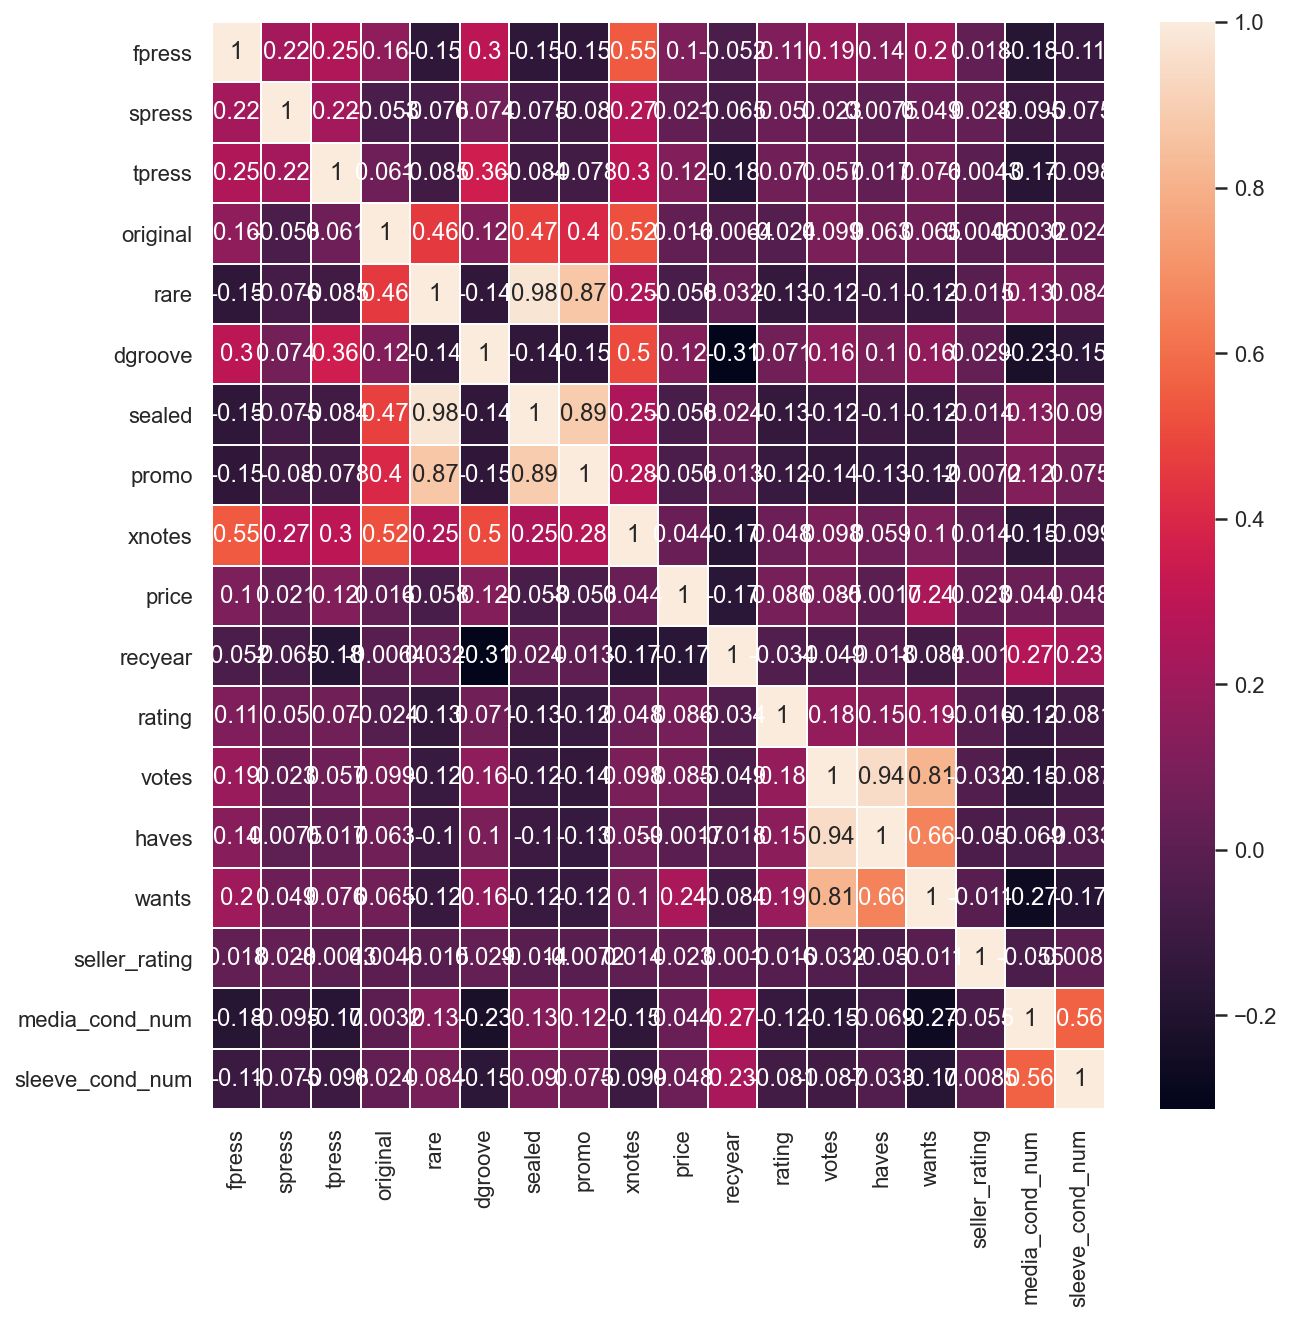

In [414]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_corr, annot=True, linewidths=.5, ax=ax)

**Crosstab Function**

In [415]:
def xtab(fieldname):
    lab_tab=df[fieldname].value_counts(ascending=False)
    lab_tab2=df[fieldname].value_counts(ascending=False,normalize=True)
    
    print(lab_tab.head(30),lab_tab2.head(30))
    
    # lab_tab = pd.crosstab(index=df["reclabel"],  # Make a crosstab
    #                               columns="count")
    # lab_tab.sort_values('reclabel', ascending=False,inplace=True)

In [416]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

**Price Hist**

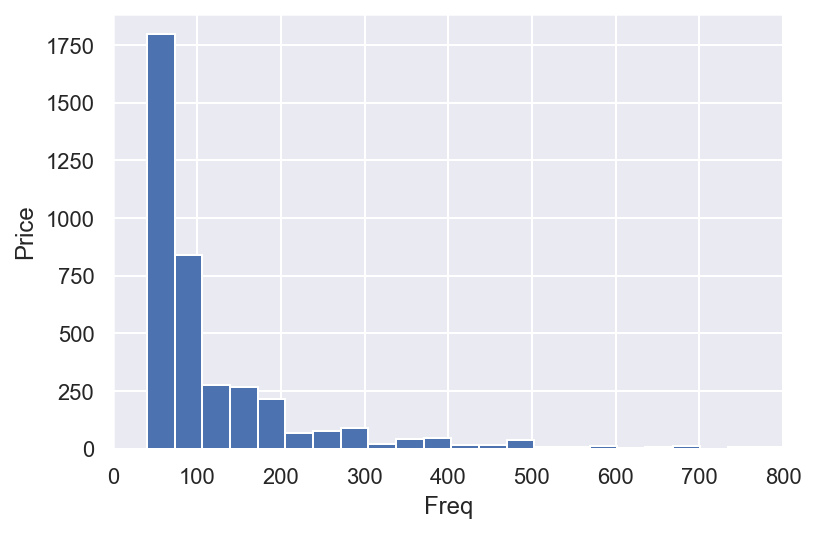

In [417]:
# Price
plt.hist(df['price'], bins =150)
plt.xlim(0,800)
plt.xlabel('Freq'),plt.ylabel('Price')
plt.show()

**Album Rating Hist**

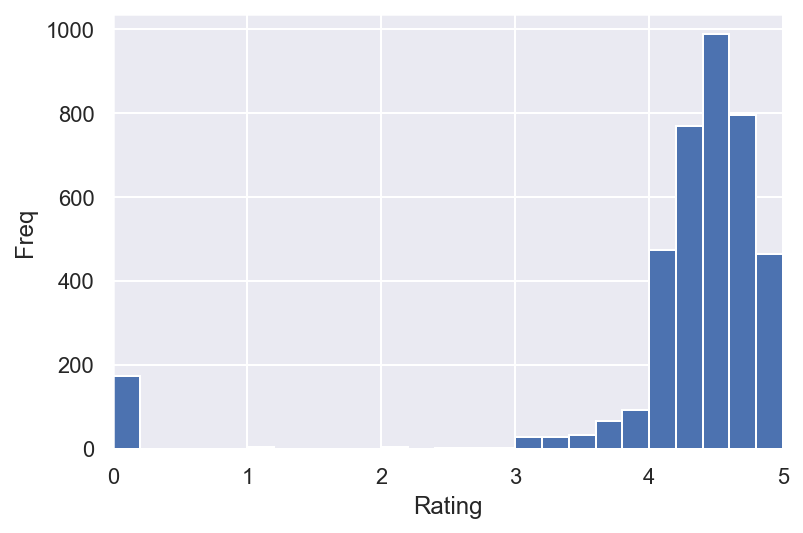

In [418]:
# rating
plt.hist(df['rating'], bins =25)
plt.xlim(0,5,0.5)
plt.xlabel('Rating'),plt.ylabel('Freq')
plt.show()

**Seller Rating Hist**

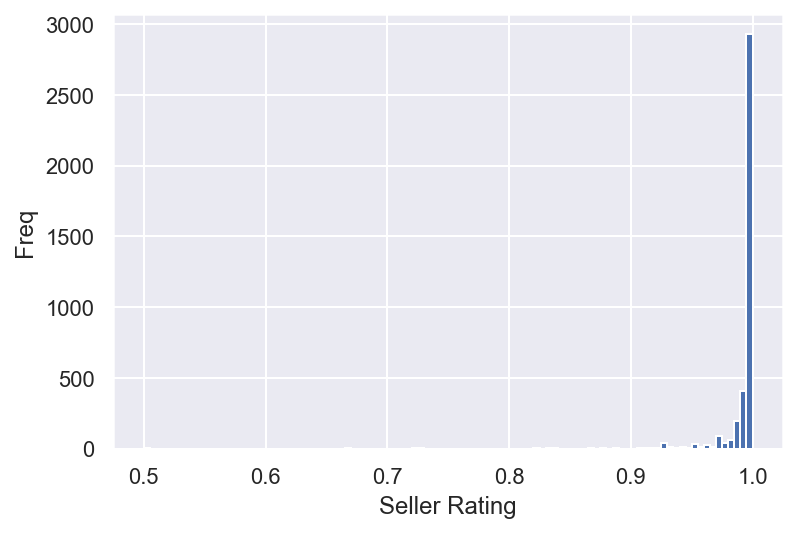

In [421]:
# seller rating
plt.hist(df['seller_rating'], bins =100)
plt.xlabel('Seller Rating'),plt.ylabel('Freq')
plt.show()

**Record Year**

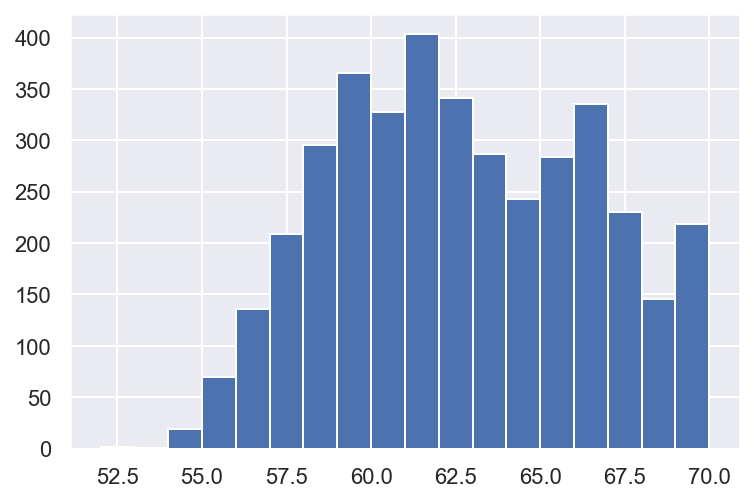

In [426]:
# record year
plt.hist(df['recyear'], bins =18)
#plt.xlim(0,800)
plt.show()

**Age is not necessarily a major factor in record price**<br>
**Therefore create categorical year**

In [427]:
df['recyearfull'] = '19'+ df['recyear'].astype(str)

In [428]:
df['recyearfull'].astype(int)

0       1956
1       1957
2       1956
3       1957
4       1961
        ... 
3908    1963
3909    1963
3910    1964
3911    1964
3912    1966
Name: recyearfull, Length: 3913, dtype: int64

**Bin Labels: Group < 100 to OTher**

In [429]:
df['labcount']=df.groupby(["reclabel"])["reclabel"].transform('count')
df.loc[df['labcount'] > 100, 'reclabel2'] = df['reclabel']
df.loc[df['labcount'] <=100,   'reclabel2'] = 'Other'
df.head(2)

,Label,Country,Genre,Release_Date,Style,fpress,spress,tpress,original,rare,...,haves,wants,sleeve_cond_abbr,media_cond_abbr,seller_rating,media_cond_num,sleeve_cond_num,recyearfull,labcount,reclabel2
0,Blue Note – BLP 1502,US,Jazz,Feb 1956,"Hard Bop, Bop",1,0,0,1,0,...,219.0,301.0,VG,VG+,0.988,6,5,1956,1243,Blue Note
1,Blue Note – BLP 1567,US,Jazz,1957,Hard Bop,0,0,0,0,0,...,68.0,385.0,VG,VG,1.000,5,5,1957,1243,Blue Note


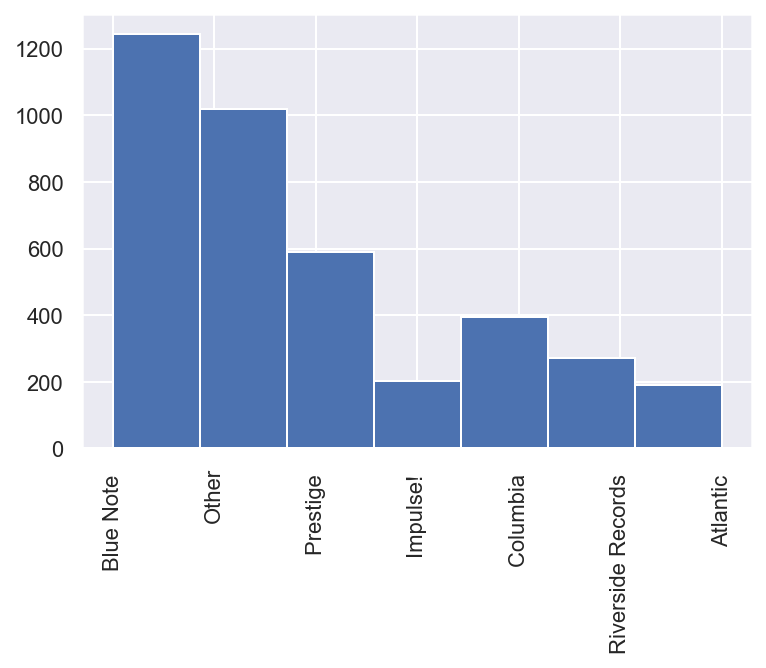

In [430]:
# hist of record label
plt.hist(df['reclabel2'], bins =7)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

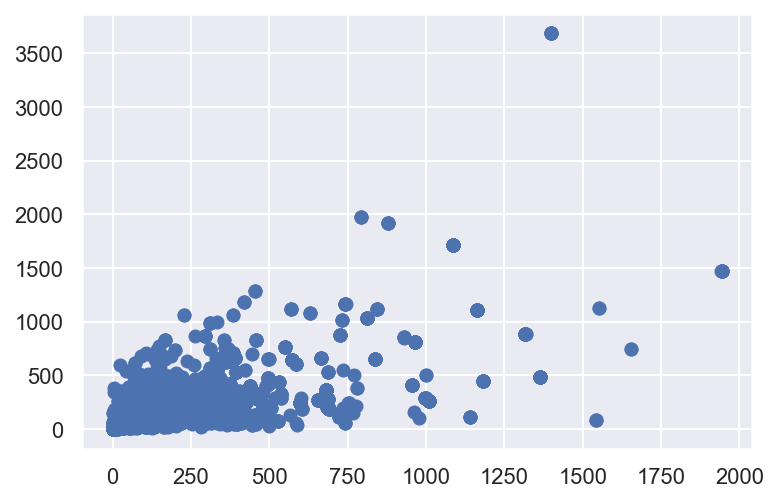

In [431]:
# haves / wants
plt.scatter(df['haves'],df['wants'])
plt.show()

**Country: may need to drop**

**Genre: drop**

In [432]:
# Media/sleeve
xtab('media_cond_num')

6    1617
5     983
7     866
4     231
8     131
3      68
2      14
1       3
Name: media_cond_num, dtype: int64 6    0.413238
5    0.251214
7    0.221314
4    0.059034
8    0.033478
3    0.017378
2    0.003578
1    0.000767
Name: media_cond_num, dtype: float64


**Artist/Album**

In [95]:
xtab('album')

 Somethin' Else                                       45
 Blowin' The Blues Away                               36
 Monk's Dream                                         35
 The Sidewinder                                       34
 Mingus Ah Um                                         31
 Seven Steps To Heaven                                29
 Miles Davis And The Modern Jazz Giants               28
 Someday My Prince Will Come                          27
 Art Blakey And The Jazz Messengers                   25
 Doin' The Thing - At The Village Gate                25
 Miles Davis At Carnegie Hall                         25
 My Favorite Things                                   25
 The Cape Verdean Blues                               23
 Finger Poppin' With The Horace Silver Quintet        23
 Jazz Track                                           23
 'Round About Midnight                                23
 A Love Supreme                                       22
 Time Out                      

**Media and Sleeve conditions**

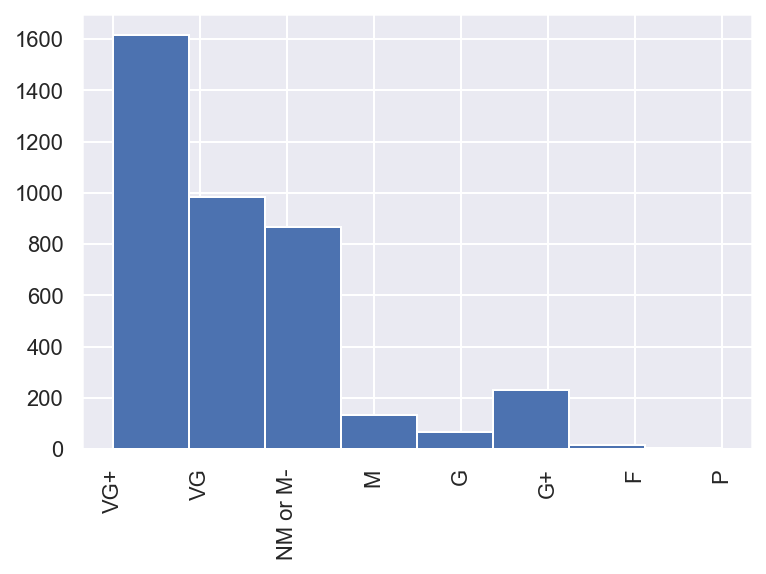

In [433]:
# hist of record label
plt.hist(df['media_cond_abbr'], bins =8)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

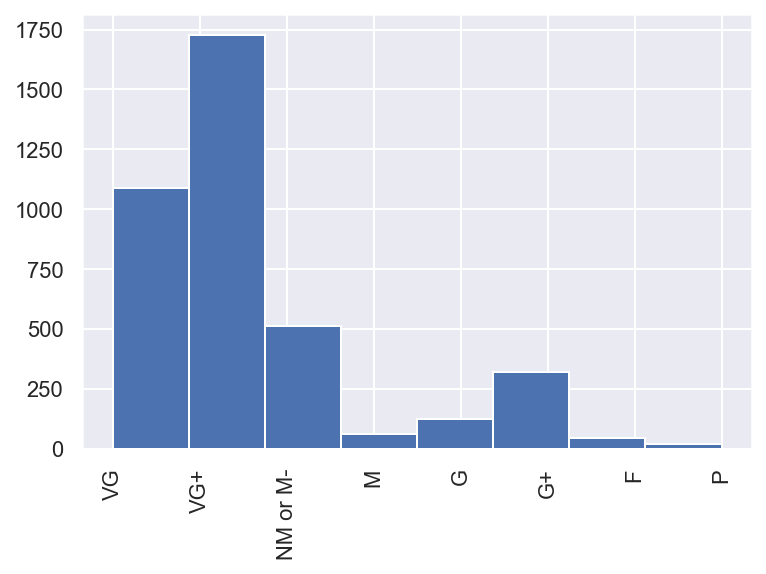

In [434]:
# sleeve
plt.hist(df['sleeve_cond_abbr'], bins =8)
#plt.xlim(0,800)
plt.xticks(rotation=90)
plt.show()

In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Label             3913 non-null   object 
 1   Country           3913 non-null   object 
 2   Genre             3913 non-null   object 
 3   Release_Date      3913 non-null   object 
 4   Style             3913 non-null   object 
 5   fpress            3913 non-null   int64  
 6   spress            3913 non-null   int64  
 7   tpress            3913 non-null   int64  
 8   original          3913 non-null   int64  
 9   rare              3913 non-null   int64  
 10  dgroove           3913 non-null   int64  
 11  sealed            3913 non-null   int64  
 12  promo             3913 non-null   int64  
 13  xnotes            3913 non-null   int64  
 14  price             3913 non-null   float64
 15  artist            3913 non-null   object 
 16  album             3913 non-null   object 


<br>

## 2. Split Train/Val vs. Test: (80/20)

**Drop cat vars that are not necessary**

In [439]:
# DRop other categorical vars that may not be useful for modeling
df2=df.drop(['reclabel','Country','Label','Genre','Release_Date','Style','artist','album','labcount','rare',
             'fpress','spress','tpress','original','sealed','promo','dgroove',
             'media_cond_abbr','sleeve_cond_abbr',
             'recyearfull'], axis=1 ) #, inplace=True)
print(df2.columns)

Index(['xnotes', 'price', 'recyear', 'rating', 'votes', 'haves', 'wants',
       'seller_rating', 'media_cond_num', 'sleeve_cond_num', 'reclabel2'],
      dtype='object')


In [ ]:
## Create your dummies prior to split

In [440]:
# on the X_, y_ use OHE since you need integers for model
df3 = pd.get_dummies(df2,drop_first=True)

In [441]:
X , y = df3.drop('price',axis=1), df3['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Index(['xnotes', 'recyear', 'rating', 'votes', 'haves', 'wants',
       'seller_rating', 'media_cond_num', 'sleeve_cond_num',
       'reclabel2_Blue Note ', 'reclabel2_Columbia ', 'reclabel2_Impulse! ',
       'reclabel2_Other', 'reclabel2_Prestige ',
       'reclabel2_Riverside Records '],
      dtype='object')
(3913, 15) (3913,)


In [442]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


## Model Approaches
- **Pair plots** (check what we might manually use second order polynomial terms - based on domain knowledge)
- **encode your categoricals**
- **model 1:** 
    - ols (2 methods)
    - no transformations
        - get idea of coeffs for features
- **model 2:**
    - CV kfold models:
    - Run ols (no transformations)        
- **model 3:**
    - CV with transformatoins
- **model 4:**
    - Run a model with polyterms and interactions
    - scale our vars
- **model 5:**
    - try a lasso model     
- **compare** if model 4 is any better than model 2 (or 1)

**Process:**
- LR
- Start run model
- Fit 
- Add features
    - Poynomial
    - interactions
- This may overfit
- Then regularize (lasso, ridge)
- Check wther it’s improved!  

**notes:**
- 3 categorical vars (xnotes (already encoded), reclabel, media condition, sleeve conditions)
- FIt = learning (done on training)
- score/transform = uses coefs from fit and uses these in models. also transforms features into poly and interactions (new cols)


<br>

### Model 1 (OLS)

In [335]:
# split train/val DF
X_train, X_val, y_train, y_val = \
        train_test_split(X_, y_, test_size=0.2, random_state=22)

# run basic ols
m1_ols = sm.OLS(y_train, X_train)
m1_ols = OLS.fit()
m1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.480
Model:                            OLS   Adj. R-squared (uncentered):              0.474
Method:                 Least Squares   F-statistic:                              84.64
Date:                Wed, 20 Jan 2021   Prob (F-statistic):                        0.00
Time:                        12:47:49   Log-Likelihood:                         -16349.
No. Observations:                2504   AIC:                                  3.275e+04
Df Residuals:                    2477   BIC:                                  3.291e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
xnotes                          -6.1880      7.035     -0.880      0.379     -19.984       7.608
recyear                        -12.5936      0.941    -13.389      0.000     -14.438     -10.749
rating                           5.9758      3.425      1.745      0.081      -0.740      12.691
votes                           -1.3933      0.565     -2.465      0.014      -2.502      -0.285
haves                           -0.1174      0.052     -2.246      0.025      -0.220      -0.015
wants                            0.3721      0.028     13.347      0.000       0.317       0.427
seller_rating                  522.7525     84.234      6.206      0.000     357.576     687.929
sleeve_cond_abbr_G              71.8396     34.056      2.109      0.035       5.057     138.622
sleeve_cond_abbr_G+             47.3238     31.401      1.507      0.132     -14.252     108.899
sleeve_cond_abbr_M              90.3166     46.398      1.947      0.052      -0.666     181.299
sleeve_cond_abbr_NM or M-       99.4972     31.631      3.146      0.002      37.472     161.522
sleeve_cond_abbr_P              63.4406     54.886      1.156      0.248     -44.187     171.068
sleeve_cond_abbr_VG             81.8185     30.133      2.715      0.007      22.730     140.907
sleeve_cond_abbr_VG+            75.7896     30.213      2.508      0.012      16.543     135.036
media_cond_abbr_G               39.6060     69.202      0.572      0.567     -96.094     175.306
media_cond_abbr_G+              94.8232     66.537      1.425      0.154     -35.651     225.297
media_cond_abbr_M              262.7478     70.723      3.715      0.000     124.065     401.430
media_cond_abbr_NM or M-       248.1913     66.084      3.756      0.000     118.605     377.778
media_cond_abbr_P               15.9652    179.319      0.089      0.929    -335.665     367.595
media_cond_abbr_VG             165.6286     65.556      2.527      0.012      37.077     294.180
media_cond_abbr_VG+            213.2497     65.663      3.248      0.001      84.489     342.010
reclabel2_Blue Note            143.4704     16.971      8.454      0.000     110.192     176.748
reclabel2_Columbia              34.5744     19.391      1.783      0.075      -3.450      72.598
reclabel2_Impulse!              49.8750     21.482      2.322      0.020       7.751      91.999
reclabel2_Other                 33.6574     17.120      1.966      0.049       0.086      67.229
reclabel2_Prestige              71.7724     17.995      3.989      0.000      36.486     107.059
reclabel2_Riverside Records     24.9256     20.369      1.224      0.221     -15.016      64.867
==========================================================================

**Fit to the Validation Set**

In [336]:
# method 1 r^2
y_pred = m1_ols.predict(X_val)

R2 = metrics.r2_score(y_val, y_pred)

MSE = metrics.mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2',R2)

MSE: 23694.897631714775
RMSE: 153.93147056958423
R2 0.16985129010247868


**good for processes**
https://towardsdatascience.com/polynomial-regression-bbe8b9d97491plt.scatter(X_val, y_val, s=10)

In [362]:
# method 2

# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_val)

# score fit model on validation data
val_score = lr_model.score(X_val, y_val)
#print('R2 from val_score:',val_score)

R2 = metrics.r2_score(y_val, y_pred)
MSE = metrics.mean_squared_error(y_val, y_pred)
RMSE = np.sqrt(MSE)
coefs=lr_model.coef_.flatten()

print('R2 from val_score:',val_score)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('R2',R2)

print('Feature coefficient results: \n')
    
for feature, coef in zip(X_.columns, coefs):
    print(feature, ':', f'{coef:.2f}') 


R2 from val_score: 0.1713891486968051
MSE: 23651.002602390312
RMSE: 153.78882469929442
R2 0.1713891486968051
Feature coefficient results: 

xnotes : -7.51
recyear : -13.22
rating : 5.27
votes : -1.37
haves : -0.12
wants : 0.37
seller_rating : 226.95
sleeve_cond_abbr_G : 65.24
sleeve_cond_abbr_G+ : 41.63
sleeve_cond_abbr_M : 83.32
sleeve_cond_abbr_NM or M- : 93.95
sleeve_cond_abbr_P : 55.51
sleeve_cond_abbr_VG : 76.63
sleeve_cond_abbr_VG+ : 71.11
media_cond_abbr_G : -7.00
media_cond_abbr_G+ : 48.42
media_cond_abbr_M : 217.85
media_cond_abbr_NM or M- : 201.18
media_cond_abbr_P : -30.33
media_cond_abbr_VG : 118.73
media_cond_abbr_VG+ : 166.65
reclabel2_Blue Note  : 142.79
reclabel2_Columbia  : 31.65
reclabel2_Impulse!  : 48.96
reclabel2_Other : 30.78
reclabel2_Prestige  : 70.09
reclabel2_Riverside Records  : 21.74


### Model 2. Kfold CV - no transformations, no standardization
- https://stackoverflow.com/questions/45394527/do-i-need-to-split-data-when-using-gridsearchcv#:~:text=1%20Answer&text=GridSearchCV%20will%20take%20the%20data,for%20example%20proportion%20of%20split).

In [363]:
# Train+val convert to array
from sklearn.model_selection import KFold

# Keep in mind X_ has cats already transformed (full training - not val)
X_kf, y_kf = np.array(X_), np.array(y_)

In [364]:
#X_train, X_val, y_train, y_val = train_test_split(X_kf, y_kf, test_size=.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

In [365]:
params = {'fit_intercept':[True,False]}
lr_model = GridSearchCV(LinearRegression(),params, cv=5)
lr_model.fit(X_kf, y_kf)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

In [366]:
lr_model.best_estimator_

LinearRegression()

In [367]:
lr_model.best_estimator_.score(X_kf, y_kf)

0.21905929758352372

*model is a little better after CV*

#### CV method 2

In [368]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


Feature coefficient results: 

xnotes : -8.57
recyear : -12.99
rating : 7.60
votes : 0.06
haves : -0.22
wants : 0.28
seller_rating : 146.25
sleeve_cond_abbr_G : 54.87
sleeve_cond_abbr_G+ : 23.17
sleeve_cond_abbr_M : 98.03
sleeve_cond_abbr_NM or M- : 73.77
sleeve_cond_abbr_P : 14.45
sleeve_cond_abbr_VG : 55.44
sleeve_cond_abbr_VG+ : 58.03
media_cond_abbr_G : 5.07
media_cond_abbr_G+ : 67.45
media_cond_abbr_M : 220.46
media_cond_abbr_NM or M- : 206.67
media_cond_abbr_P : -29.30
media_cond_abbr_VG : 134.26
media_cond_abbr_VG+ : 177.31
reclabel2_Blue Note  : 127.43
reclabel2_Columbia  : 29.61
reclabel2_Impulse!  : 36.40
reclabel2_Other : 27.05
reclabel2_Prestige  : 60.15
reclabel2_Riverside Records  : 9.17
Feature coefficient results: 

xnotes : -7.68
recyear : -13.09
rating : 5.26
votes : -0.11
haves : -0.20
wants : 0.31
seller_rating : 309.31
sleeve_cond_abbr_G : 61.75
sleeve_cond_abbr_G+ : 32.26
sleeve_cond_abbr_M : 97.15
sleeve_cond_abbr_NM or M- : 91.03
sleeve_cond_abbr_P : 67.42
sleev

**GridSearch yielded slightly better results**

### Model 3. CV no transformations, with standardization

**Transforming Variables -KF CV**

In [370]:
# recrate x,y (no encodeing_)

X , y = df2.drop('price',axis=1), df2['price']
print(X.columns)
print(X.shape,y.shape)

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Index(['xnotes', 'recyear', 'rating', 'votes', 'haves', 'wants',
       'sleeve_cond_abbr', 'media_cond_abbr', 'seller_rating', 'reclabel2'],
      dtype='object')
(3913, 10) (3913,)


In [371]:
#X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.2, random_state=42)

In [372]:
column_trans = ColumnTransformer(
    transformers= [
        ('ss',StandardScaler(), ['recyear','rating','votes','haves','wants','seller_rating']),
        ('ohe',OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2'])
    ],
    remainder='passthrough')
    
lr = LinearRegression()

cvmod = make_pipeline(column_trans, lr)

print(cross_val_score(cvmod, X=X_, y=y_, cv=5))
print(cross_val_score(cvmod, X=X_, y=y_, cv=5).mean())

[0.18958455 0.13889567 0.21882238 0.22042513 0.20202472]
0.19395049019743427


*model is worse after standardizing/encoding*

### Model 4. Linear Regression with polyterms and interactions and standardization

In [378]:
# recrate x,y (with encodeing)
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

X , y = df3.drop('price',axis=1), df3['price']

# hold out 20% of the data for final testing (as array below)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [379]:
m = LinearRegression()
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_)
s = StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)

m.fit(X_train_poly_scaled,y_)
m.score(X_train_poly_scaled,y_)

0.43503175944506056

### Model 5. Lasso Regression with CV, poly/interactions, standardizations

In [395]:
m = LassoCV(tol=0.0001)
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_)
s = StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_poly)
m.fit(X_train_poly_scaled,y_)
m.score(X_train_poly_scaled,y_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16868.108724325895, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17284.874268494546, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20443.622214578092, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2900673.6989412606, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3192695.565929629, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3326426.4022833556, tolerance: 9481.886348337695
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2200114.558922015, tolerance: 9035.974663017183
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2486709.8137052953, tolerance: 9035.974663017183
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2546325.220187925, tolerance: 9035.974663017183
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: C

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2126472.873431165, tolerance: 8113.342929114377
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2133596.2991056666, tolerance: 8113.342929114377
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2109170.7967395447, tolerance: 8113.342929114377
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100342.86197709292, tolerance: 7259.32478224639
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173492.08987957984, tolerance: 7259.32478224639
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248336.70920785517, tolerance: 7259.32478224639
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: Co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122729.95077081025, tolerance: 8695.327555039794
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175128.0831104815, tolerance: 8695.327555039794
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209249.99966809154, tolerance: 8695.327555039794
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: 

0.380817068488973

In [388]:
m.score(s.transform(p.transform(X_test)),y_test)

0.28375363833147316

In [392]:
list(zip(p.get_feature_names(['xnotes','recyear','rating','votes','haves','wants',
                                'seller_rating','sleeve_cond_abbr_G',
                                'sleeve_cond_abbr_G+','sleeve_cond_abbr_M',
                                'media_cond_abbr_NM or M-','media_cond_abbr_P',
                                'media_cond_abbr_VG','media_cond_abbr_VG+',
                                'reclabel2_Blue Note','reclabel2_Columbia',
                                'reclabel2_Impulse!','reclabel2_Other',
                                'reclabel2_Prestige','reclabel2_Riverside Records']),m.coef_))

IndexError: list index out of range

### Model 6. Ridge Regression with CV, poly/interactions, standardizations

In [384]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

alphas = np.arange(0.001,1.0,0.001) 

hyper_param_grid = {'alpha': alphas, 'fit_intercept': [True, False]}

ridge_model = GridSearchCV(Ridge(), hyper_param_grid, cv=5) # , n_jobs=-1)

ridge_model.fit(X_, y_)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.0...
       0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953, 0.954,
       0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962, 0.963,
       0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971, 0.972,
       0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981,
       0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99 ,
       0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]),
                         'fit_intercept': [True, False]})

In [385]:
ridge_model.best_estimator_

Ridge(alpha=0.975)

In [387]:
ridge_model.best_estimator_.score(X_,y_)

0.21872578998223813

## TESTING
- https://github.com/allisonhonold/column_transformer_ferry_wait_blog/blob/master/columntransformer_example.ipynb
- https://towardsdatascience.com/using-columntransformer-to-combine-data-processing-steps-af383f7d5260
- https://pbpython.com/categorical-encoding.html

**using sckikit learn (works)**

In [265]:
# column_trans = make_column_transformer(
#     (OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2']),
#     remainder='passthrough')
# lr = LinearRegression() 

column_trans = ColumnTransformer(
    transformers= [
        ('ss',StandardScaler(), ['recyear','rating','votes','haves','wants','seller_rating']),
        ('ohe',OneHotEncoder(), ['sleeve_cond_abbr', 'media_cond_abbr','reclabel2'])
    ],
    remainder='passthrough')
    
#lr = LinearRegression() 

In [266]:
lr = LinearRegression()

pipe = make_pipeline(column_trans, lr)
# pipe = Pipeline([
#             ("preprocessing", column_trans),
#             ("lr", lr)
#        ])

In [267]:
print(cross_val_score(pipe, X=X_, y=y_, cv=5))#.mean()
print(cross_val_score(pipe, X=X_, y=y_, cv=5).mean())


[0.18958455 0.13889567 0.21882238 0.22042513 0.20202472]
0.19395049019743427


#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [121]:
print(X_.shape,y_.shape)

(3130, 10) (3130,)


In [223]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    # both one hot and continous go here. if you have issues, use iloc.
    
    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train.values)
    
    
    X_train = pd.get_dummies(X_train,drop_first=True)
    X_val   = pd.get_dummies(X_val,drop_first=True)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    
    print(X_val.shape,y_val.shape)
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    #print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        

In [224]:
split_and_validate(X_,y_)

ValueError: could not convert string to float: 'VG'

### 4b. Add polynomial

In [ ]:
X2 = X_.copy()

X2['seller_rating2'] = X2['seller_rating'] ** 2
X2['rating2'] = X2['rating'] ** 2

In [ ]:
split_and_validate(X2,y_)

### 4c. Add interaction

In [1]:
X3 = X_.copy()

type(X3)
# multiplicative interaction
X3['rate_x_vote'] = X3['rating'] * X3['votes']

# division interaction
X3['want_over_have'] = X3['wants'] / X3['haves']

NameError: name 'X_' is not defined

In [ ]:
split_and_validate(X3,y_)

<br>

### 5. Simple Linear Model (Cross Validation)

#### Setting up for modeling and building a baseline:

In [219]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    
#     X_train_ohe = pd.get_dummies(X_train)#,drop_first=True)
#     X_val_ohe   = pd.get_dummies(X_val)# ,drop_first=True)
    
#     print(X_train_ohe)
    
#     scaler = StandardScaler()    
#     X_train_s = scaler.fit_transform(X_train.values)
#     X_val_s = scaler.fit_transform(X_val.values)
    
#     X_train=pd.concat([X_train_ohe,X_train_s],axis=1)
#     X_val=pd.concat([X_val_ohe,X_val_s],axis=1)
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


      xnotes  recyear  rating  votes   haves   wants  seller_rating  \
2359       0       65    4.68  205.0  1398.0  3685.0          1.000   
3762       1       64    4.72  109.0   965.0   810.0          1.000   
2132       0       64    0.00    0.0    20.0    17.0          1.000   
2392       0       62    4.54   13.0    75.0   155.0          1.000   
2650       1       63    5.00   10.0    78.0   169.0          1.000   
...      ...      ...     ...    ...     ...     ...            ...   
3772       1       66    4.27   60.0   778.0   212.0          1.000   
1095       0       57    5.00    1.0     9.0    66.0          1.000   
1130       1       56    4.25   12.0   104.0    99.0          0.929   
860        1       62    0.00    0.0     2.0     1.0          0.984   
3507       1       66    4.29   14.0    73.0    64.0          1.000   

      sleeve_cond_abbr_F  sleeve_cond_abbr_G  sleeve_cond_abbr_G+  ...  \
2359                   0                   0                    0  ...   

ValueError: could not convert string to float: 'VG+'

### 5b. Polynomial model

In [ ]:
#run the CV
# use the X,y KF arrays

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

kf = KFold(n_splits=5, shuffle=True, random_state = 42)
cv_lm_r2s = [] #collect the validation results

for train_ind, val_ind in kf.split(X_kf,y_kf):
    
    # cc. this splits your training 80% and val 20% through n iterations
    # none of type int64 (error) resolved using iloc
    X_train, y_train = X_.iloc[train_ind], y_.iloc[train_ind]    
    X_val, y_val = X_.iloc[val_ind], y_.iloc[val_ind] 
    
    '''
     cc. preprocessing (standardize, one hot) -on TRAINING
     start with nums, copy array, apply one hot, run model
     right now is done on training + Val sets
    '''
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train.values)
    
    
    
    ''' 
    #poly with degree 2
    poly = PolynomialFeatures(degree=2)
    
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    
    lm_poly.fit(X_train_poly, y_train)
    cv_lm_poly_r2s.append(round(lm_poly.score(X_val_poly, y_val), 3))
    
print('Poly scores: ', cv_lm_poly_r2s, '\n')

print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}')
    '''
    
    
    
    #simple linear regression
    lm = LinearRegression()

    # cc. this runs a linear model on trainign to obtain coeffs
    lm.fit(X_train, y_train)
    
    # cc. this takes the coeffs of training and applies to model on validation
    # we only output the r2 scores of the validation model here
    cv_lm_r2s.append(round(lm.score(X_val, y_val), 3))
    
    '''
    Obtain the coeff per features
    '''
    #needed to flatten the array
    coefs=lm.coef_.flatten()
    
    print('Feature coefficient results: \n')
    
    for feature, coef in zip(X_.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
    
    '''
    Print the R^2 scores and mean scores
    '''
    
print('Simple regression scores: ', cv_lm_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')


**Observations**
- votes, haves and wants may be colinear with price
- there are some peaks in years that have higher values
- most seller ratings are high, the highest demand the highest price
- some positive correlation with rating and price

#### Setting up for modeling and building a baseline:

Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [ ]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    '''
     preprocessing 
    '''
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    
    print('\nValidation R^2 score was:', val_score)
    #print(X.columns, lr_model.coef_)
    
    # needed to flatten the array
    coefs=lr_model.coef_.flatten()
    #X_cols= X.columns #flatten()
    
    print('Feature coefficient results: \n')
    
    #print(list(zip(lr_model.coef_, X.columns)))    
    
    #for feature, coef in zip(X.columns, coefs):                
    for feature, coef in zip(X_df.columns, coefs):
        print(feature, ':', f'{coef:.2f}') 
        #list(map('{:.2f}%'.format,x))

## 4. Intermediate feature engineering: categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

**Categorical conversions:**

- sleeve / media conditions: Can change to ordinal ranks
- artist rankings: Can rank artists based on frequency of list
- reclabel: may need to bin depending
- country: may need to bin
- pressed by: may need to bin
- recoreded at: may need to bin
- style: may or may not use
- notes: if we get notes, parse out keywords and turn into booleans:
    . first, 1st, second, 2nd, original, rare, deep groove